### importing






In [1]:
!pip install keras

In [69]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Input,Conv2D,MaxPool2D,BatchNormalization ,Dense,Flatten,Layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras import metrics
import keras

In [ ]:
dataset,dataset_info=tfds.load('malaria', as_supervised=True, with_info=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpxd9mdwhutfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [6]:
dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
print(type(dataset[0]))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [8]:
def splits(dataset,train_ratio,val_ration,test_ration):
    dataset_size=len(dataset)

    train_data=dataset.take(int(train_ratio*dataset_size))
    dataset=dataset.skip(int(train_ratio*dataset_size))
    val_data=dataset.take(int(val_ration*dataset_size))
    test_data=dataset.take(int(test_ration*dataset_size))

    return train_data,val_data,test_data

In [9]:
Train_ration=0.8
Val_ration=0.1
Test_ration=0.1

train_dataset,val_dataset,test_dataset=splits(dataset[0],Train_ration,Val_ration,Test_ration)


In [10]:
dataset_len={
    'train':len(train_dataset),
    'val':len(val_dataset),
    'test':len(test_dataset)
}

print(dataset_len)

{'train': 22046, 'val': 2755, 'test': 2755}


## Data Visualization

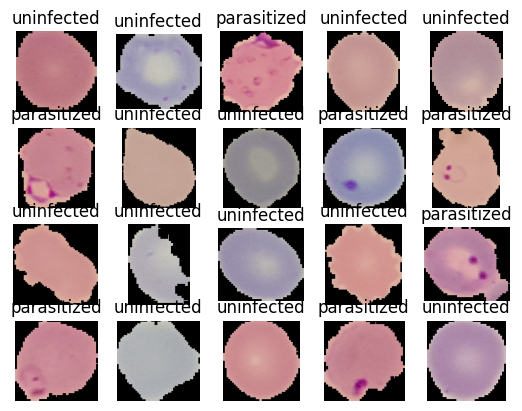

In [11]:
for i ,(image,label) in enumerate(train_dataset.take(20)):
    ax=plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')


In [13]:
for image,labes in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [14]:
def image_resige(image,label):
  image=tf.image.resize(image,(224,224))/255.0
  return image,label

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


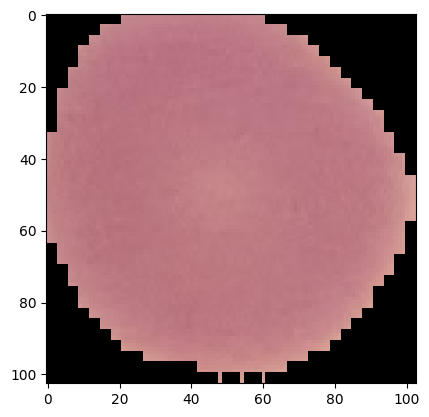

In [15]:
for image,label in train_dataset.take(1):
  print(image,label)
  plt.imshow(image)

In [16]:
train_dataset=train_dataset.map(image_resige)

tf.Tensor(1, shape=(), dtype=int64)


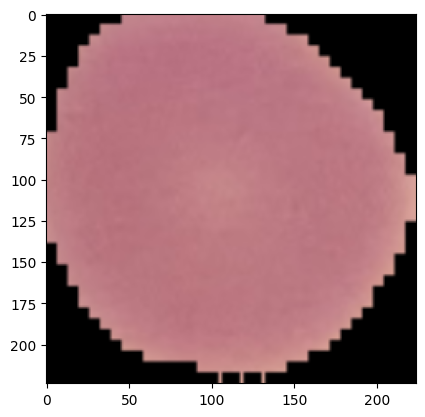

In [17]:
for image,label in train_dataset.take(1):
  print(label)
  plt.imshow(image)

In [18]:
val_dataset=val_dataset.map(image_resige)
test_dataset=test_dataset.map(image_resige)

In [19]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

batching , resampling of data

In [20]:
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
print(train_dataset.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [25]:
model_lenet=tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),
    Conv2D(filters=6, kernel_size=3,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    #______________________________________
    Conv2D(filters=16,kernel_size=3,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    #______________________________________
    Flatten(),
    Dense(units=100,activation="relu"),
    BatchNormalization(),
    Dense(units=10,activation="relu"),
    BatchNormalization(),
    Dense(units=1,activation="sigmoid")

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [26]:
model_lenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
model_lenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[Accuracy()]
)

In [ ]:
history=model_lenet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - accuracy: 0.0000e+00 - loss: 0.5573 - val_accuracy: 0.0000e+00 - val_loss: 0.6026
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 63s 64ms/step - accuracy: 0.0000e+00 - loss: 0.2254 - val_accuracy: 0.0000e+00 - val_loss: 0.1760
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 90s 75ms/step - accuracy: 0.0000e+00 - loss: 0.1524 - val_accuracy: 0.0000e+00 - val_loss: 0.1880
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - accuracy: 0.0000e+00 - loss: 0.1274 - val_accuracy: 0.0000e+00 - val_loss: 0.2240
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - accuracy: 0.0000e+00 - loss: 0.0912 - val_accuracy: 0.0000e+00 - val_loss: 0.2608
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - accuracy: 7.2741e-07 - loss: 0.0737 - val_accuracy: 0.0000e+00 - val_loss: 0.1853
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - accuracy: 4.3406e-05 - loss: 0.0486 - val_accuracy: 0.0029 - val_loss: 0.2287
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━

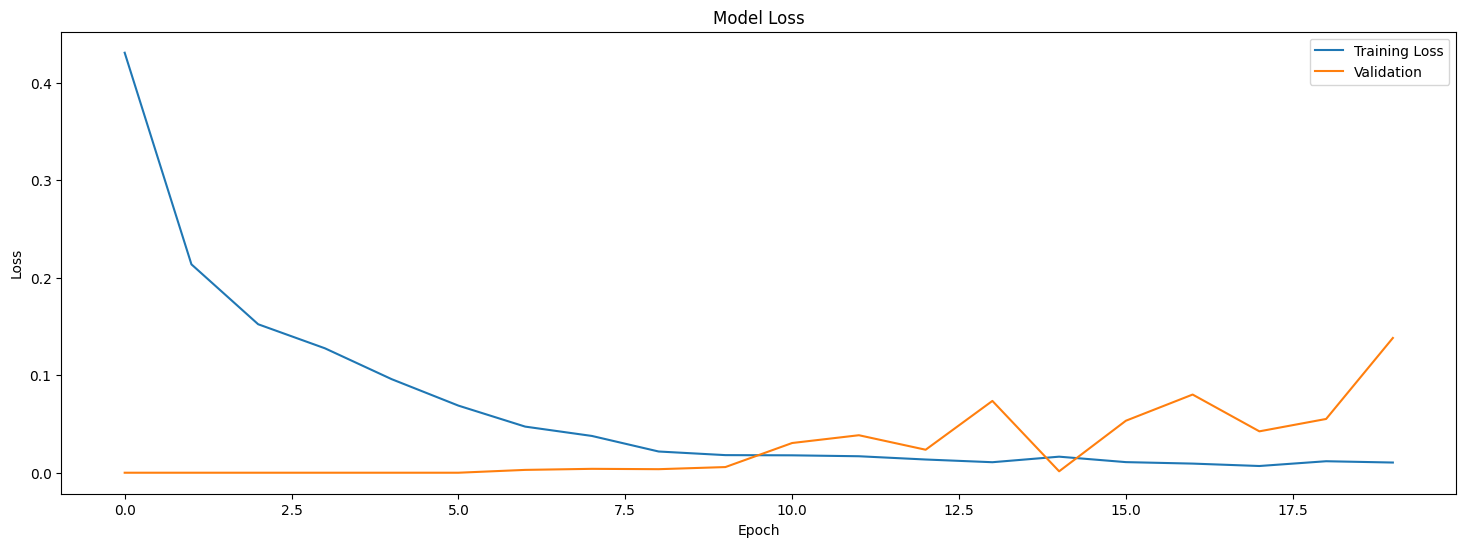

In [ ]:
#Plot training & validation loss values

plt.figure(figsize=(18, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_dataset=test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model_lenet.predict(test_dataset.take(1)).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


(1, 1)

In [ ]:
model_lenet.evaluate(test_dataset)

2755/2755 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.1343 - loss: 0.3126


[0.37012821435928345, 0.1382940113544464]

In [ ]:
model_lenet.save('my_model.keras')
model_lenet.save('my_model.h5', save_format='h5')


In [ ]:
for image, label in test_dataset.take(1):
  print(label)


tf.Tensor([0], shape=(1,), dtype=int64)


In [28]:
parasite_or_not(model_lenet.predict(test_dataset.take(1))[0][0])

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(224, 224, 3), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(224, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [27]:
def parasite_or_not(x):
  if x>0.5:
    return 1
  else:
    return 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


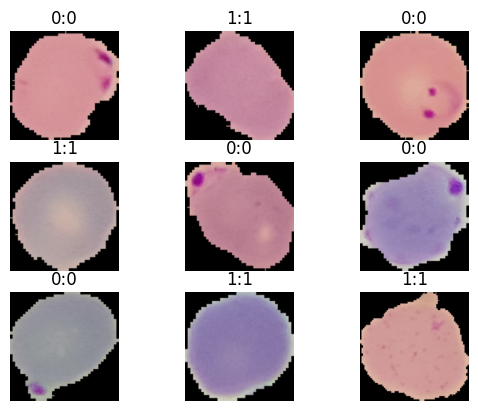

In [ ]:

for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model_lenet.predict(image)[0][0])))

  plt.axis('off')


In [ ]:
model_lenet.save("/content/lenet.h5")

model_lenet.save_weights("/content/lenet_weights.weights.h5") # Added '.weights' to the filename to meet the Keras requirement

#lenet_weights_model = model_lenet.load_weights("weights/lenet_weights")

In [40]:
IM_SIZE=224


class FeatureExtractor(Layer):
  def __init__(self, filter_size, kernel, stride_size, paddings, activations ,pool_size):
    super(FeatureExtractor,self).__init__()

    self.conv1=Conv2D(filters=filter_size, kernel_size=kernel, strides=stride_size, padding=paddings, activation=activations)
    self.batch1=BatchNormalization()
    self.max_pool1=MaxPool2D(pool_size=pool_size,strides=2)

    self.conv2=x=Conv2D(filters=filter_size*2, kernel_size=kernel,strides=stride_size,padding=paddings,activation=activations)
    self.batch1=BatchNormalization()
    self.max_pool2=MaxPool2D(pool_size=pool_size, strides=2)

  def call(self, x, training):
    x=self.conv1(x)
    x=self.batch1(x)
    x=self.max_pool1(x)

    x=self.conv2(x)
    x=self.batch2(x)
    x=self.max_pool2(x)

    return x

feature_sub_classed = FeatureExtractor(6, 3, 1, "valid", "relu", 2)

In [43]:
funct= Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(funct,training=False)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(funct, func_output, name = "Lenet_Model")


lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor_5                  │ (None, 54, 54, 16)          │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [55]:
class Lenet_model(Model):
  def __init__(self):
    super(Lenet_model,self).__init__()

    self.feature_extractor=FeatureExtractor(6,3,1,"valid","relu",2)

    self.flatten1=Flatten()
    self.dense_1=Dense(100,activation="relu")
    self.batch_norm1=BatchNormalization()

    self.dense_2=Dense(10,activation="relu")
    self.batch_norm2=BatchNormalization()

    self.dense_out=Dense(1, activation="relu")


  def call(self,x,training):
    x=self.feature_extractor(x,training=False)
    x=self.flatten1(x)
    x=self.dense_1(x)
    x=self.batch_norm1(x)

    x=self.dense_2(x)
    x=self.batch_norm2(x)

    x=self.dense_out(x)

    return x



lenet_sub_classed = Lenet_model()
lenet_sub_classed.summary()


Model: "lenet_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_13                 │ ?                           │     0 (unbuilt) │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### callbaks

In [59]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [84]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [80]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  return learning_rate


scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [62]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

In [71]:
metric = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [72]:
lenet_sub_classed.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=metric
)

In [82]:
lenet_sub_classed.summary()

Model: "lenet_model_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_13                 │ ?                           │             900 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 34992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │       3,499,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,504,473 (40.07 MB)

 Trainable params: 3,501,405 (13.36 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 7,002,812 (26.71 MB)

In [ ]:
history=lenet_sub_classed.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[csv_callback, es_callback, scheduler_callback, plateau_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - accuracy: 0.5035 - auc: 0.5000 - fn: 0.0000e+00 - fp: 5518.7725 - loss: 7.9147 - precision: 0.5035 - recall: 1.0000 - tn: 0.0000e+00 - tp: 5537.1753 - val_accuracy: 0.5053 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 1363.0000 - val_loss: 7.8873 - val_precision: 0.5053 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 1392.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 47s 68ms/step - accuracy: 0.5036 - auc: 0.5000 - fn: 0.0000e+00 - fp: 5518.7275 - loss: 7.9138 - precision: 0.5036 - recall: 1.0000 - tn: 0.0000e+00 - tp: 5537.2202 - val_accuracy: 0.5053 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 1363.0000 - val_loss: 7.8873 - val_precision: 0.5053 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 1392.0000 - learning_rate: 0.0010


In [ ]:
b